# CS5242 Final Project Reports

### Authors: Team 23 --- **Shao Guoxin(A0232474H)**, **Deng Yichao**, **Zhang Delong**

</br>
</br>

For past two years, as people began to increasingly wear **masks** around the world, the prevailing view was it represented a huge challenge to facial recognition. However, we still need traditional facial detection systems to work during the pandemic. As shown in Figures.

<p>
<img src="http://www.xinhuanet.com/english/2019-09/27/138428955_15695888042401n.jpg" width="400">

</p>
Payment Device 1 (image from xinhuanet.com).

<img src="https://static.themoscowtimes.com/image/1360/1e/1F27B415-36F0-40BD-8182-4CD065EB47E7.jpeg" width="400">
Payment Device 2 (image from themoscowtimes.com).

<img src="https://img0.baidu.com/it/u=2560709678,2228068383&fm=26&fmt=auto" width="400">

Face verification (image from baidu.com)

It seemed obvious - algorithms designed to analyse faces would be less accurate if part of the face was concealed. And also, **take off mask in public results in the risk of infection increasing**. Therefore,  we would like to solve this issue by adopting Deep Learning model. We want to focus on face with mask detection in this project, and will give a try to do face 1:1 verification analysis. 

## Table of Content

- [x] [Initialization](#initialization)
- [x] [Data Pre-Processing](#data-pre)
- [x] MLP Model
- [x] CNN Model
- [x] CNN_RNN_Model
- [x] ANN Model
- [x] Training
- [x] Evaluation
- [x] Analysis
- [x] Conculusion
- [x] References

## 1. Initialization <a name="initialization"></a>

In [78]:
import os
import cv2
import random
import math
from os import chdir
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision import transforms
from torchvision.transforms import *
import sys
import torch
import torch.nn as nn
import numpy as np
gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
projectDirectory = os.getcwd()
chdir(projectDirectory)

Using GPU NVIDIA GeForce RTX 2080 Ti


## DataSet & Data Pre-Processing <a name="data-pre"></a>

#### Load our `train_set` and `test_set` by `CNNRNNDataSet`
We load data from folder `"./train/"` and `"./test/"` for train and test respectively


In [79]:
def read_image(path):
    return Image.open(path)


class CNNRNNDataSet(Dataset):
    
    def __init__(self, is_train=True):
        self.label_map = {'face':2, 'nomask':1, 'nonface':0}
        self.data_dir = projectDirectory + '/data/'
        self.labels = []
        self.is_train = is_train
        
        if is_train:
            self.data_dir += 'train/'
        else:
            self.data_dir += 'test/'
        
        for fn in os.listdir(self.data_dir):
            fn = fn.replace('.png', '')
            self.labels.append(fn)
        
        self.preprocess = Compose([ 
            Resize((100,100)),
            RandomHorizontalFlip(),
            ToTensor(),
        ])
        self.test_process = Compose([
            Resize((100, 100)),
            ToTensor()
        ])
        # GaussianBlur(kernel_sizev=(5, 9), sigma=(0.1, 5),
        print(f'loaded data from {self.data_dir}. dataset size {len(self)}')

    def __getitem__(self, idx):
        name = self.labels[idx]
        image = read_image(os.path.join(self.data_dir, f'{name}.png'))
        
        if image.mode == "RGBA":
            r, g, b, a = im.split ()
            image =Image.merge ("RGB", (r, g, b))
        elif image.mode!="RGB":
            image = image.convert ("RGB")
            
        if self.is_train:
            image = self.preprocess(image)
        else:
            image = self.test_process(image)
        return image, self.label_map[name.split('_')[1]]

    def __len__(self):
        return len(self.labels)

## CNN_RNN_Model

In [116]:
import torch.nn as nn
from torchvision import * 
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class CNNRNNModel(nn.Module):

    def __init__(self):
        super().__init__()

        # Build the CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d((2, 2)), #50
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),#25
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),#13
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)), #7
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),#3
            nn.Dropout(p=0.5),
        )
        self.fc = nn.Linear(512  * 3 * 3, 2048, bias=True)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(2048, 2048)
        self.fc2 = nn.Linear(2048, 3)
        
    def forward(self, image):
        feature = self.cnn(image)
        feature = self.fc(feature.flatten(1))
        feature,_ = self.lstm(self.relu(feature.unsqueeze(1)))
        return self.fc2(feature.flatten(1))
    
m = CNNRNNModel()
data = torch.randn(1, 3, 100, 100)
m(data)

tensor([[-0.0810, -0.0869, -0.1149]], grad_fn=<AddmmBackward0>)

## Train

In [118]:
import time
import torch
import multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AverageMeter(object):
    """
    A utility class to compute statisitcs of losses and accuracies
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_lr(optimizer):
    '''
    Get the current learning rate
    '''
    for param_group in optimizer.param_groups:
        return param_group['lr']


def topk_accuracy(k, outputs, targets):
    """
    Compute top k accuracy
    """
    batch_size = targets.size(0)

    _, pred = outputs.topk(k, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.type(torch.FloatTensor).sum().item()

    return n_correct_elems / batch_size

batch_size = 64
num_epochs = 50
num_workers = 2
model = CNNRNNModel()
# model = nn.DataParallel(model.to(device).float(), device_ids=[0, 1, 2, 3])

def train():
    train_set = CNNRNNDataSet(is_train=True)
    validation_set = CNNRNNDataSet(is_train=False)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    lr = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.3)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, val_loss = AverageMeter(), AverageMeter()
        train_acc, val_acc = AverageMeter(), AverageMeter()
        model.train()
        for i, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device).view(-1)
            optimizer.zero_grad()
            image.requires_grad_()
            prediction = model(image)
            loss = criterion(prediction, label)
            train_loss.update(loss.detach().item())

            acc = topk_accuracy(1, prediction, label)
            train_acc.update(acc)

            loss.backward()
            optimizer.step()

            if i % 2 == 1:
                print(f'training: iteration {i} / {len(train_loader)}, avg train loss = {train_loss.avg:.4f}, '
                      f'train accuracy {train_acc.avg:.4f}')

        # validation
        model.eval()
        for i, (image, label) in enumerate(validation_loader):
            image, label = image.to(device), label.to(device).view(-1)      
                      
            with torch.no_grad():
                prediction = model(image)

                loss = criterion(prediction, label)
                val_loss.update(loss.item())

                acc = topk_accuracy(1, prediction, label)
                val_acc.update(acc)

            if i % 10 == 9:
                print(f'validation: iteration {i} / {len(validation_loader)}, avg val loss = {val_loss.avg:.4f}, '
                      f'val accuracy {val_acc.avg:.4f}')

        # epoch summary
        print(f'Epoch {epoch}, train error {train_loss.avg:.4f}, val error {val_loss.avg:.4f}. '
              f'Train acc = {train_acc.avg:.4f}, val acc = {val_acc.avg:.4f}. '
              f'Time cost {(time.time() - start_time) / 60:.2f} min.\n')

        # lr scheduler
        scheduler.step(val_loss.avg)

        # checkpoint
        if epoch % 2 == 1:
            torch.save(model.state_dict(), f'ckpt_e{epoch}.pth')

    torch.save(model.state_dict(), 'my_model.pt')


if __name__ == "__main__":
    train()
    print("Done")


loaded data from /home/g/guoxin/study/CS5242/final/data/train/. dataset size 883
loaded data from /home/g/guoxin/study/CS5242/final/data/test/. dataset size 176
training: iteration 1 / 14, avg train loss = 1.0967, train accuracy 0.3516
training: iteration 3 / 14, avg train loss = 1.0902, train accuracy 0.3711
training: iteration 5 / 14, avg train loss = 1.0901, train accuracy 0.3646
training: iteration 7 / 14, avg train loss = 1.0792, train accuracy 0.3984
training: iteration 9 / 14, avg train loss = 1.0799, train accuracy 0.3859
training: iteration 11 / 14, avg train loss = 1.0782, train accuracy 0.4023
training: iteration 13 / 14, avg train loss = 1.0748, train accuracy 0.4044
Epoch 0, train error 1.0748, val error 1.0989. Train acc = 0.4044, val acc = 0.2969. Time cost 0.74 min.

training: iteration 1 / 14, avg train loss = 1.0330, train accuracy 0.5859
training: iteration 3 / 14, avg train loss = 1.0303, train accuracy 0.5664
training: iteration 5 / 14, avg train loss = 1.0312, tra

## Test

loaded data from /home/g/guoxin/study/CS5242/final/data/test/. dataset size 176


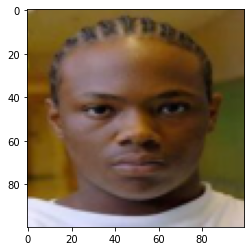

prediction: tensor(0)


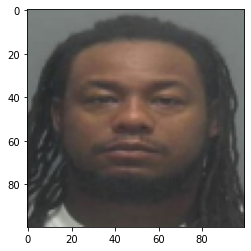

prediction: tensor(2)


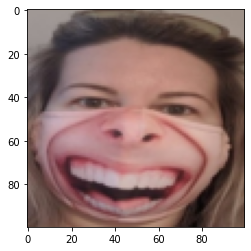

prediction: tensor(1)
test: iteration 1 / 9, test accuracy 0.9000
test: iteration 3 / 9, test accuracy 0.9125
test: iteration 5 / 9, test accuracy 0.9250
test: iteration 7 / 9, test accuracy 0.9313
evaluation finished, val acc 0.9181


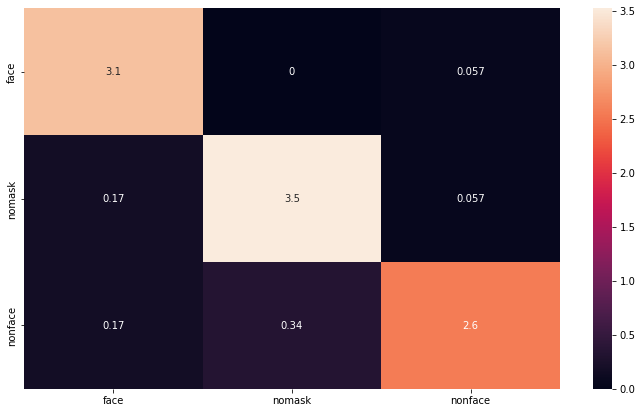

In [119]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

def test():
    model = CNNRNNModel()
    model = model.to('cpu')
    model.eval()
    batch_size = 20

    model.load_state_dict(torch.load('ckpt_e35.pth', map_location='cpu'), strict=False)
    test_set = CNNRNNDataSet(is_train=False)


    # mp.set_start_method('spawn', force=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                      shuffle=False)
    prt = True
    # test accuracy
    test_acc = AverageMeter()
    for i, (image, label) in enumerate(test_loader):
        image, label = image, label.view(-1)
        with torch.no_grad():
            prediction = model(image)
            if prt:
                prt = False
                _, pred = prediction.topk(1, 1, True)
                pred = pred.t()
                res = pred.eq(label).cpu().numpy()
                for idx, val in enumerate(res[0]):
                    if not val:
                        show(image[idx].cpu())
                        print("prediction:", torch.argmax(prediction[idx]))
            acc = topk_accuracy(1, prediction, label)
            test_acc.update(acc)
            output = (torch.max(torch.exp(prediction), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            label = label.data.cpu().numpy()
            y_true.extend(label) # Save Truth
            
        if i % 2 == 1:
            print(f'test: iteration {i} / {len(test_loader)}, '
                  f'test accuracy {test_acc.avg:.4f}')

    print(f'evaluation finished, val acc {test_acc.avg:.4f}')
    # constant for classes
    classes = ("face", "nomask", "nonface")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

if __name__ == "__main__":
    test()


## References